<a href="https://colab.research.google.com/github/kimtomato/Kaggle_Project/blob/master/titanic_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimtomato","key":"192f0ed7ad3b2981ab307f629f96ca08"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 5.72MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.7MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 88.2MB/s]


In [176]:
import numpy as np
import pandas as pd 
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2.0)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [177]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
#Skewness>0 , 값이 너무 쏠려있어서 scale 바꾸기 
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i>0 else 0)


## Feature Engineering

1. dataset에 존재하는 null data 채워주기 (어떻게 채울지에 따라 모델의 성능이 바뀜)
2. train 뿐 아니라 test set에도 동일하게 적용해주기 


In [178]:
# Age에 대한 feature engineering
df_train['Age'].isnull().sum() #null data 개수 확인 

#공통점을 가진 그룹안에서 통계적인 수치를 가지고 null data 채우기 
#여기서는 이름의 호칭을 가지고 그룹을 만든 후에 그 그룹안에서의 나이의 통계적 수치 이용
#이때 정규 표현식 사용하기

177

In [179]:
df_train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [180]:
df_train['initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.') #대문자 A-Z, 소문자 a-z 까지 하나의 character가 한개 이상이며 거기에 .이 붙은것을 extract
df_test['initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [181]:
df_train.head() #initial이 추가된것 확인 가능

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr


In [182]:
pd.crosstab(df_train['initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #이것을 토대로 5개의 그룹으로 치환해주기

initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [183]:
df_train['initial'].replace(['Mlle','Mme', 'Ms','Dr', 'Major','Lady','Countess','Jonkheer','Col','Rev', 'Capt','Sir','Don','Dona'],
                            ['Miss', 'Miss','Miss', 'Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace=True) #inplace를 적어줘야 바로 적용이 된다. 
df_test['initial'].replace(['Mlle','Mme', 'Ms','Dr', 'Major','Lady','Countess','Jonkheer','Col','Rev', 'Capt','Sir','Don','Dona'],
                            ['Miss', 'Miss','Miss', 'Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace=True) #inplace를 적어줘야 바로 적용이 된다. 

In [184]:
df_train.groupby('initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


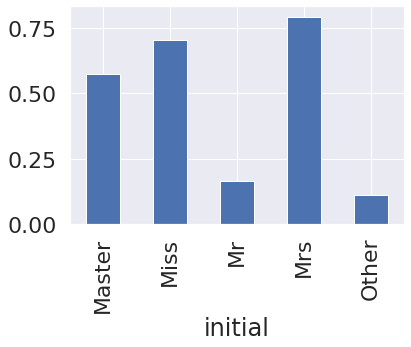

In [185]:
#그룹별로 생존률이 어떻게 달라지는지
df_train.groupby('initial')['Survived'].mean().plot.bar()

In [186]:
#null value 채워보기 train + test
#두개의 dataFrame 합칠때 concat(쌓는것이라고 생각), merge(같은 column기준으로 합침) 이용  

df_all=pd.concat([df_train, df_test])

In [187]:
df_all #index는 그대로 1-800, 1-500  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,2.085672,NaN,S,1,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,4.690430,C105,C,1,Mr
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,S,1,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,2.085672,NaN,S,1,Mr


In [188]:
#index 바꿔주려면
df_all.reset_index(drop = True) #drop을 True로 설정해둬야 원래 있던 index 삭제

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,2.085672,NaN,S,1,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,4.690430,C105,C,1,Mr
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,1.981001,NaN,S,1,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,2.085672,NaN,S,1,Mr


In [189]:
df_all.groupby('initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
initial,,,,,,,,
Master,658.852459,0.575000,2.655738,5.482642,2.049180,1.377049,3.262225,4.426230
Miss,616.992453,0.704301,2.332075,21.834533,0.652830,0.494340,3.065227,2.147170
Mr,658.831388,0.162571,2.359274,32.556397,0.286641,0.159533,2.680701,1.446174
Mrs,685.673367,0.795276,1.929648,37.034884,0.658291,0.824121,3.488188,2.482412
Other,714.923077,0.111111,1.615385,44.923077,0.230769,0.153846,2.951897,1.384615


In [190]:
#우리가 원하는 row나 columu을 반환하는 인덱싱 문법중 location 문법 사용
df_train.loc[1:2, :]
#iloc랑 loc 비교 해보기 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss


In [191]:
df_train.loc[df_train['Survived']==1] #'Survived 가 1인 값들만 모두 반환


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,2.409941,NaN,S,3,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,3.403555,NaN,C,2,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,1.977547,NaN,C,1,Miss
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,4.420746,C50,C,2,Mrs
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,3.258097,NaN,S,2,Mrs
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,3.401197,B42,S,1,Miss


In [192]:
(df_train['Age'].isnull())&(df_train['initial']=='Mr') 

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [193]:
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Mr')] #Mr 이면서 나이가 null로 채워진 data 반환

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,2.135148,NaN,Q,1,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,2.564949,NaN,S,1,Mr
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,1.977547,NaN,C,1,Mr
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,2.066331,NaN,S,1,Mr
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,1.978128,NaN,C,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,3.391147,C47,C,1,Mr
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,4.242046,NaN,S,11,Mr
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,1.978128,NaN,C,1,Mr
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,2.251292,NaN,S,1,Mr


In [194]:
#numpy 브로드캐스팅, 원하는 숫자를 다 넣어줄수있음 , null data에 모두 값 넣어주기
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Mr'),'Age'] = 33
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Mrs'),'Age'] = 37
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Master'),'Age'] = 5
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Other'),'Age'] = 45
df_train.loc[(df_train['Age'].isnull())&(df_train['initial']=='Miss'),'Age'] = 22


#test에도 똑같이 적용
df_test.loc[(df_test['Age'].isnull())&(df_test['initial']=='Mr'),'Age'] = 33
df_test.loc[(df_test['Age'].isnull())&(df_test['initial']=='Mrs'),'Age'] = 37
df_test.loc[(df_test['Age'].isnull())&(df_test['initial']=='Master'),'Age'] = 5
df_test.loc[(df_test['Age'].isnull())&(df_test['initial']=='Other'),'Age'] = 45
df_test.loc[(df_test['Age'].isnull())&(df_test['initial']=='Miss'),'Age'] = 22

In [195]:
df_train['Age'].isnull().sum()  #null data가 모두 없어진것 확인 가능

0

## Embarked - null data 채우기

In [145]:
df_train['Embarked'].isnull().sum() #두개만 존재 

2

In [196]:
#두개만 존재함으로 찾아서 통계값을 넣어주기보다는 가장 빈도가 높은 값으로 채워줌 (891개중)
df_train.shape

(891, 14)

In [197]:
df_train['Embarked'].fillna('S', inplace =True)

In [198]:
df_train['Embarked'].isnull().sum() #Null data 채워진 것 확인


0

## continuous feature를 카테고리로 만들기 

단점 : 정보의 손실이 발생할 수 있다

In [199]:
df_train['Age_cat'] = 0

In [200]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr,0


In [201]:

#Age를 카테고리로 구분 -1
df_train.loc[df_train['Age']<10, 'Age_cat'] =0
df_train.loc[(10<=df_train['Age'])&(df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(20<=df_train['Age'])&(df_train['Age']<30), 'Age_cat'] = 2
df_train.loc[(30<=df_train['Age'])&(df_train['Age']<40), 'Age_cat'] = 3
df_train.loc[(40<=df_train['Age'])&(df_train['Age']<50), 'Age_cat'] = 4
df_train.loc[(50<=df_train['Age'])&(df_train['Age']<60), 'Age_cat'] = 5
df_train.loc[(60<=df_train['Age'])&(df_train['Age']<70), 'Age_cat'] = 6
df_train.loc[(70<=df_train['Age']),'Age_cat'] = 7

#test도 변환
df_test.loc[df_train['Age']<10, 'Age_cat'] =0
df_test.loc[(10<=df_test['Age'])&(df_test['Age']<20), 'Age_cat'] = 1
df_test.loc[(20<=df_test['Age'])&(df_test['Age']<30), 'Age_cat'] = 2
df_test.loc[(30<=df_test['Age'])&(df_test['Age']<40), 'Age_cat'] = 3
df_test.loc[(40<=df_test['Age'])&(df_test['Age']<50), 'Age_cat'] = 4
df_test.loc[(50<=df_test['Age'])&(df_test['Age']<60), 'Age_cat'] = 5
df_test.loc[(60<=df_test['Age'])&(df_test['Age']<70), 'Age_cat'] = 6
df_test.loc[(70<=df_test['Age']),'Age_cat'] = 7




In [202]:

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr,3


In [203]:
#Age를 카테고리로 구분 -2 apply 함수 이용  **이 방식을 추천
def category_age(x):
    if x < 10:
        return 0 

    elif x < 20:
        return 1

    elif x < 30:
        return 2

    elif x < 40:
        return 3

    elif x < 50:
        return 4

    elif x < 60:
        return 5

    elif x < 70:
        return 6
    
    else:
        return 7


In [204]:
df_train['Age'].apply(category_age)

0      2
1      3
2      2
3      3
4      3
      ..
886    2
887    1
888    2
889    2
890    3
Name: Age, Length: 891, dtype: int64

In [205]:
#column 데이터 날려버림
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

In [206]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,1.981001,NaN,S,2,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,4.266662,C85,C,2,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,3.972177,C123,S,2,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,2.085672,NaN,S,1,Mr,3


## string 데이터를 수치데이터로 바꿔보기 

string 데이터를 그대로 사용할 경우 제대로 인식하기 어렵기 때문에 숫자로 바꿔주는것이 좋음

In [207]:
df_train.initial.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [208]:
df_train['initial'] = df_train['initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['initial'] =df_test['initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [209]:
#특정 column feature에 어떤 값들이 있는지 확인-1
df_train.Embarked.unique()  #numpy array


array(['S', 'C', 'Q'], dtype=object)

In [210]:
#특정 column feature에 어떤 값들이 있는지 확인-2
df_train['Embarked'].value_counts() # Series 타입


S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [211]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q': 1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q': 1,'S':2})

In [214]:
df_train.head() #이니셜과 Embarked가 숫자로 바뀜

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,2.085672,NaN,2,1,2,3


In [219]:
df_train.Embarked.isnull().any() #any()는 true가 하나라도 존재하면 true, all은 모두 true여야 true

False

In [220]:
df_train.Sex.unique()

array(['male', 'female'], dtype=object)

In [221]:
df_train.Sex = df_train.Sex.map({'male':1, 'female':0})
df_test['Sex'] = df_test['Sex'].map({'male':1, 'female':0})

In [222]:
df_train.head() 

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,initial,Age_cat
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,3
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,3
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,2,3


각 feature들간의 선형적 상관관계 확인하기 Pearson's correlation 

선형이므로 correlation이 1이면 양의 선형 관계 \
선형이므로 correlation이 -1이면 반비례 \
0이면 선형 관계가 없는것


In [223]:
# 8X8로 각각의 상관관계를 모두 확인 - heatmap 이용
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'initial','Age_cat']]

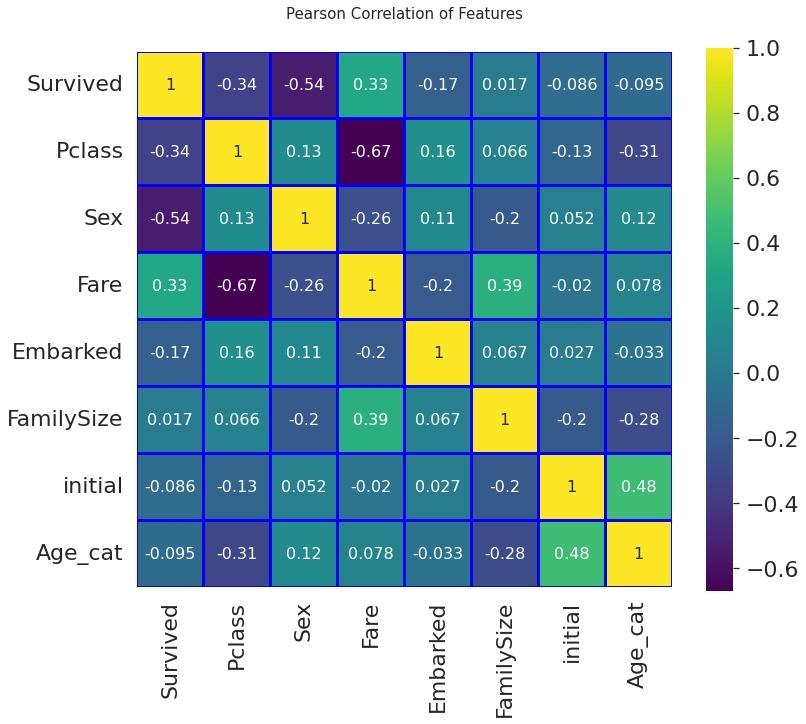

In [235]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation of Features', y = 1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(),linewidths=2.0, vmax=1.0,
            square=True, cmap=colormap, linecolor='blue', annot=True, annot_kws={'size':16}) #astype :  heatmap data의 모든 데이터를 float으로 바꿔줌 , corr(): pandas dataFrame에 corr 적용시 모든 상관관계를 구해줌 